<br>
<font>
<div dir=ltr align=center>

<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
NLP - Transformer & Bert <br>
</div>
<div dir=ltr align=center>
</div>

____

# Section 1: Transformer

The transformer architecture consists of two main components: an encoder and a decoder. Each of these components is made up of multiple layers that include self-attention mechanisms and feedforward neural networks. The self-attention mechanism is central to the transformer, as it enables the model to assess the importance of different words in a sentence by considering their relationships with one another.


In this assignment, you should design a transformer model from scratch. You are required to implement the Encoder and Decoder components of a Transformer model.

In [ ]:
!pip install datasets

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

## Part 1: Input Embeddings
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">When we observe the Transformer architecture image above, we can see that the Embeddings represent the first step of both blocks.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>InputEmbedding</code> class below is responsible for converting the input text into numerical vectors of <code>d_model</code> dimensions. To prevent that our input embeddings become extremely small, we normalize them by multiplying them by the $\sqrt{d_{model}}$.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the image below, we can see how the embeddings are created. First, we have a sentence that gets split into tokens—we will explore what tokens are later on—. Then, the token IDs—identification numbers—are transformed into the embeddings, which are high-dimensional vectors.</p>

In [ ]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

## Part 2: positional encoding
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the original paper, the authors add the positional encodings to the input embeddings at the bottom of both the encoder and decoder blocks so the model can have some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two vectors can be summed and we can combine the semantic content from the word embeddings and positional information from the positional encodings.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>PositionalEncoding</code> class below, we will create a matrix of positional encodings <code>pe</code> with dimensions <code>(seq_len, d_model)</code>. We will start by filling it with $0$s.We will then apply the sine function to even indices of the positional encoding matrix while the cosine function is applied to the odd ones.</p>

<p style="
    margin-bottom: 5;
    font-size: 22px;
    font-weight: 300;
    font-family: 'Helvetica Neue', sans-serif;
    color: #000000;
  ">
    \begin{equation}
    \text{Odd Indices } (2i + 1): \quad \text{PE(pos, } 2i + 1) = \cos\left(\frac{\text{pos}}{10000^{2i / d_{model}}}\right)
    \end{equation}
</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We apply the sine and cosine functions because it allows the model to determine the position of a word based on the position of other words in the sequence, since for any fixed offset $k$, $PE_{pos + k}$ can be represented as a linear function of $PE_{pos}$. This happens due to the properties of sine and cosine functions, where a shift in the input results in a predictable change in the output.</p>

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(seq_len, d_model)

        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)

        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self,x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

## Part 3: layer normalization
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">When we look at the encoder and decoder blocks, we see several normalization layers called <b><i>Add &amp; Norm</i></b>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>LayerNormalization</code> class below performs layer normalization on the input data. During its forward pass, we compute the mean and standard deviation of the input data. We then normalize the input data by subtracting the mean and dividing by the standard deviation plus a small number called epsilon to avoid any divisions by zero. This process results in a normalized output with a mean 0 and a standard deviation 1.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will then scale the normalized output by a learnable parameter <code>alpha</code> and add a learnable parameter called <code>bias</code>. The training process is responsible for adjusting these parameters. The final result is a layer-normalized tensor, which ensures that the scale of the inputs to layers in the network is consistent.</p>

In [ ]:

class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps

        self.alpha = nn.Parameter(torch.ones(1))

        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)

        return self.alpha * (x-mean) / (std + self.eps) + self.bias



## Part 4: Feed Forward Network
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the fully connected feed-forward network, we apply two linear transformations with a ReLU activation in between. We can mathematically represent this operation as:</p>

<p style="
    margin-bottom: 5;
    font-size: 22px;
    font-weight: 300;
    font-family: 'Helvetica Neue', sans-serif;
    color: #000000;
  ">
    \begin{equation}
    \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
    \end{equation}
</p>


<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">$W_1$ and $W_2$ are the weights, while $b_1$ and $b_2$ are the biases of the two linear transformations.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>FeedForwardBlock</code> below, we will define the two linear transformations—<code>self.linear_1</code> and <code>self.linear_2</code>—and the inner-layer <code>d_ff</code>. The input data will first pass through the <code>self.linear_1</code> transformation, which increases its dimensionality from <code>d_model</code> to <code>d_ff</code>. The output of this operation passes through the ReLU activation function, which introduces non-linearity so the network can learn more complex patterns, and the <code>self.dropout</code> layer is applied to mitigate overfitting. The final operation is the <code>self.linear_2</code> transformation to the dropout-modified tensor, which transforms it back to the original <code>d_model</code> dimension.</p>

In [ ]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

## Part 5: Multi Head Attention
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The Multi-Head Attention is the most crucial component of the Transformer. It is responsible for helping the model to understand complex relationships and patterns in the data.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The image below displays how the Multi-Head Attention works. It doesn't include <code>batch</code> dimension because it only illustrates the process for one single sentence.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The Multi-Head Attention block receives the input data split into queries, keys, and values organized into matrices $Q$, $K$, and $V$. Each matrix contains different facets of the input, and they have the same dimensions as the input.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We then linearly transform each matrix by their respective weight matrices $W^Q$, $W^K$, and $W^V$. These transformations will result in new matrices $Q'$, $K'$, and $V'$, which will be split into smaller matrices corresponding to different heads $h$, allowing the model to attend to information from different representation subspaces in parallel. This split creates multiple sets of queries, keys, and values for each head.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Finally, we concatenate every head into an $H$ matrix, which is then transformed by another weight matrix $W^o$ to produce the multi-head attention output, a matrix $MH-A$ that retains the input dimensionality.</p>

In [ ]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, 'd_model is not divisible by h'
        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)


## Part 6: Residual Connection
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">When we look at the architecture of the Transformer, we see that each sub-layer, including the <i>self-attention</i> and <i>Feed Forward</i> blocks, adds its output to its input before passing it to the <i>Add &amp; Norm</i> layer. This approach integrates the output with the original input in the <i>Add &amp; Norm</i> layer. This process is known as the skip connection, which allows the Transformer to train deep networks more effectively by providing a shortcut for the gradient to flow through during backpropagation.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>ResidualConnection</code> class below is responsible for this process.</p>

In [ ]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

## Part 7: Encoder
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will now build the encoder. We create the <code>EncoderBlock</code> class, consisting of the Multi-Head Attention and Feed Forward layers, plus the residual connections.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the original paper, the Encoder Block repeats six times. We create the <code>Encoder</code> class as an assembly of multiple <code>EncoderBlock</code>s. We also add layer normalization as a final step after processing the input through all its blocks.</p>

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Part 8: Decoder
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Similarly, the Decoder also consists of several DecoderBlocks that repeat six times in the original paper. The main difference is that it has an additional sub-layer that performs multi-head attention with a <i>cross-attention</i> component that uses the output of the Encoder as its keys and values while using the Decoder's input as queries.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">For the Output Embedding, we can use the same <code>InputEmbeddings</code> class we use for the Encoder. You can also notice that the self-attention sub-layer is <i>masked</i>, which restricts the model from accessing future elements in the sequence.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will start by building the <code>DecoderBlock</code> class, and then we will build the <code>Decoder</code> class, which will assemble multiple <code>DecoderBlock</code>s.</p>

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">You can see in the Decoder image that after running a stack of <code>DecoderBlock</code>s, we have a Linear Layer and a Softmax function to the output of probabilities. The <code>ProjectionLayer</code> class below is responsible for converting the output of the model into a probability distribution over the <i>vocabulary</i>, where we select each output token from a vocabulary of possible tokens.</p>

In [ ]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1)

## Part 9: Building the Transformer

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We finally have every component of the Transformer architecture ready. We may now construct the Transformer by putting it all together.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>Transformer</code> class below, we will bring together all the components of the model's architecture.</p>

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    def project(self, x):
        return self.projection_layer(x)

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The architecture is finally ready. We now define a function called <code>build_transformer</code>, in which we define the parameters and everything we need to have a fully operational Transformer model for the task of <b>machine translation</b>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will set the same parameters as in the original paper, <a href = "https://arxiv.org/pdf/1706.03762.pdf"><i>Attention Is All You Need</i></a>, where $d_{model}$ = 512, $N$ = 6, $h$ = 8, dropout rate $P_{drop}$ = 0.1, and $d_{ff}$ = 2048.</p>

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

The model is now ready to be trained!

## Part 10: Tokenizer

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Tokenization is a crucial preprocessing step for our Transformer model. In this step, we convert raw text into a number format that the model can process.  </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">There are several Tokenization strategies. We will use the <i>word-level tokenization</i> to transform each word in a sentence into a token.</p>

<center>
    <img src = "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F8d5e749c-b0bd-4496-85a1-9b4397ad935f_1400x787.jpeg" width = 800, height= 800>
<p style = "font-size: 16px;
            font-family: 'Georgia', serif;
            text-align: center;
            margin-top: 10px;">Different tokenization strategies. Source: <a href = "https://shaankhosla.substack.com/p/talking-tokenization">shaankhosla.substack.com</a>.</p>
</center>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">After tokenizing a sentence, we map each token to an unique integer ID based on the created vocabulary present in the training corpus during the training of the tokenizer. Each integer number represents a specific word in the vocabulary.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Besides the words in the training corpus, Transformers use special tokens for specific purposes. These are some that we will define right away:</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>• [UNK]:</b> This token is used to identify an unknown word in the sequence.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>• [PAD]:</b> Padding token to ensure that all sequences in a batch have the same length, so we pad shorter sentences with this token. We use attention masks to <i>"tell"</i> the model to ignore the padded tokens during training since they don't have any real meaning to the task.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>•  [SOS]:</b> This is a token used to signal the <i>Start of Sentence</i>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>•  [EOS]:</b> This is a token used to signal the <i>End of Sentence</i>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>build_tokenizer</code> function below, we ensure a tokenizer is ready to train the model. It checks if there is an existing tokenizer, and if that is not the case, it trains a new tokenizer.</p>

In [ ]:
def build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    if not Path.exists(tokenizer_path):

        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()

        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2)

        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

## Part 11: Load Dataset

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">For this task, we will use the <a href = "opus_books · Datasets at Hugging Face">OpusBooks dataset</a>, available on 🤗Hugging Face. This dataset consists of two features, <code>id</code> and <code>translation</code>. The <code>translation</code> feature contains pairs of sentences in different languages, such as Spanish and Portuguese, English and French, and so forth.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">I first tried translating sentences from English to Portuguese—my native tongue — but there are only 1.4k examples for this pair, so the results were not satisfying in the current configurations for this model. I then tried to use the English-French pair due to its higher number of examples—127k—but it would take too long to train with the current configurations. I then opted to train the model on the English-Italian pair, the same one used in the <a href = "https://youtu.be/ISNdQcPhsts?si=253J39cose6IdsLv">Coding a Transformer from scratch on PyTorch, with full explanation, training and inference
</a> video, as that was a good balance between performance and time of training.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We start by defining the <code>get_all_sentences</code> function to iterate over the dataset and extract the sentences according to the language pair defined—we will do that later.</p>

In [ ]:
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>get_ds</code> function is defined to load and prepare the dataset for training and validation. In this function, we build or load the tokenizer, split the dataset, and create DataLoaders, so the model can successfully iterate over the dataset in batches. The result of these functions is tokenizers for the source and target languages plus the DataLoader objects.</p>

In [ ]:
def get_ds(config):
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split='train')
    ds_raw = ds_raw.select(range(int(0.2 * len(ds_raw))))
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We define the <code>casual_mask</code> function to create a mask for the attention mechanism of the decoder. This mask prevents the model from having information about future elements in the sequence. </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We start by making a square grid filled with ones. We determine the grid size with the <code>size</code> parameter. Then, we change all the numbers above the main diagonal line to zeros. Every number on one side becomes a zero, while the rest remain ones. The function then flips all these values, turning ones into zeros and zeros into ones. This process is crucial for models that predict future tokens in a sequence.</p>

In [ ]:
def casual_mask(size):
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>BilingualDataset</code> class processes the texts of the target and source languages in the dataset by tokenizing them and adding all the necessary special tokens. This class also certifies that the sentences are within a maximum sequence length for both languages and pads all necessary sentences.</p>

In [ ]:
class BilingualDataset(Dataset):
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()
        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64)
            ]
        )

        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64)
            ]
        )

        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64)
            ]
        )

        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }


## Part 12: Validation Loop

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will now create two functions for the validation loop. The validation loop is crucial to evaluate model performance in translating sentences from data it has not seen during training.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will define two functions. The first function, <code>greedy_decode</code>, gives us the model's output by obtaining the most probable next token. The second function, <code>run_validation</code>, is responsible for running the validation process in which we decode the model's output and compare it with the reference text for the target sentence.</p>

In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')
    encoder_output = model.encode(source, source_mask)
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

In [ ]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval()
    count = 0
    console_width = 80
    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            if count == num_examples:
                break

## Part 13: Training Loop

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We are ready to train our Transformer model on the OpusBook dataset for the English to Italian translation task.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We first start by defining the <code>get_model</code> function to load the model by calling the <code>build_transformer</code> function we have previously defined. This function uses the <code>config</code> dictionary to set a few parameters.</p>

In [ ]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">I have mentioned the <code>config</code> dictionary several times throughout this notebook. Now, it is time to create it.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the following cell, we will define two functions to configure our model and the training process.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>get_config</code> function, we define crucial parameters for the training process. <code>batch_size</code> for the number of training examples used in one iteration, <code>num_epochs</code> as the number of times the entire dataset is passed forward and backward through the Transformer, <code>lr</code> as the learning rate for the optimizer, etc. We will also finally define the pairs from the OpusBook dataset, <code>'lang_src': 'en'</code> for selecting English as the source language and <code>'lang_tgt': 'it'</code> for selecting Italian as the target language.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>get_weights_file_path</code> function constructs the file path for saving or loading model weights for any specific epoch.</p>

In [ ]:
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512,
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }



def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder']
    model_basename = config['model_basename']
    model_filename = f"{model_basename}{epoch}.pt"
    return str(Path('.')/ model_folder/ model_filename)

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We finally define our last function, <code>train_model</code>, which takes the <code>config</code> arguments as input. </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In this function, we will set everything up for the training. We will load the model and its necessary components onto the GPU for faster training, set the <code>Adam</code> optimizer, and configure the <code>CrossEntropyLoss</code> function to compute the differences between the translations output by the model and the reference translations from the dataset. </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Every loop necessary for iterating over the training batches, performing backpropagation, and computing the gradients is in this function. We will also use it to run the validation function and save the current state of the model.</p>

In [ ]:
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    writer = SummaryWriter(config['experiment_name'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)
    initial_epoch = 0
    global_step = 0

    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        batch_iterator = tqdm(train_dataloader, desc=f'Processing epoch {epoch:02d}')

        for batch in batch_iterator:
            model.train()
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            label = batch['label'].to(device)
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

We can now train the model!

In [ ]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore')
    config = get_config()
    train_model(config)

Using device cuda
Max length of source sentence: 190
Max length of target sentence: 159


Processing epoch 00: 100%|██████████| 728/728 [04:35<00:00,  2.64it/s, loss=4.885]


--------------------------------------------------------------------------------
SOURCE: "No matter--a girl of your sense will not object to the voyage or the distance."
TARGET: — Che cosa importa? Una ragazza ragionevole come voi non si sgomenta né del viaggio né della distanza.
PREDICTED: — Non mi , — disse , — disse .
--------------------------------------------------------------------------------
SOURCE: You are--" He stopped, ran his eye over my dress, which, as usual, was quite simple: a black merino cloak, a black beaver bonnet; neither of them half fine enough for a lady's-maid.
TARGET: Tacque e volse uno sguardo sul mio vestito, che era semplice come al solito e quasi indegno di una cameriera.
PREDICTED: — Non mi , ma mi , ma mi , ma mi , ma mi , ma mi .


Processing epoch 01: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=4.997]


--------------------------------------------------------------------------------
SOURCE: I should not shrink from you with disgust as I did from her: in your quiet moments you should have no watcher and no nurse but me; and I could hang over you with untiring tenderness, though you gave me no smile in return; and never weary of gazing into your eyes, though they had no longer a ray of recognition for me.
TARGET: "Se foste calma, non avreste altro guardiano che me, vi saprei vegliare con infinita tenerezza; benché non potreste ricompensarmi con nessun sorriso, non mi stancherei di guardare i vostri occhi, anche se non mi riconoscessero.
PREDICTED: " Non vi , — mi , — mi , — , — , — , — , — , — , — , — , — , — , — , — , — , — , — , — , , , — , — , — , , — , — , — , — , — , — , — , — , — , — , — , — , — , — , — , — , , , , , , , , , — , , , , , , , , , , , , , , , , , , , , — , — , , , , , — , , , , , , , , , , — , , , , , — , , , , , — , — , , , , , — , , , , , , , , , , , , , — , , , , 

Processing epoch 02: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=5.050]


--------------------------------------------------------------------------------
SOURCE: This state of things should have been to me a paradise of peace, accustomed as I was to a life of ceaseless reprimand and thankless fagging; but, in fact, my racked nerves were now in such a state that no calm could soothe, and no pleasure excite them agreeably.
TARGET: Avrei dovuto credermi in paradiso, assuefatta come ero a continui rimproveri e a sforzi incompresi; ma i miei nervi erano così scossi, che la calma non poteva più calmarli, e il piacere non poteva più eccitarli piacevolmente. Bessie scese in cucina e mi portò una piccola torta, su un bel piatto cinese coperto di uccelli del paradiso, posati su convolvoli e bocci di rose.
PREDICTED: " il mio , e non il mio , ma non il mio , e il mio , e il mio , e il mio , e il mio , e , e , e il mio .
--------------------------------------------------------------------------------
SOURCE: So much has religion done for me; turning the original materi

Processing epoch 03: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=4.031]


--------------------------------------------------------------------------------
SOURCE: The candle, wasted at last, went out; as it expired, I perceived streaks of grey light edging the window curtains: dawn was then approaching.
TARGET: Alla fine la candela si spense e mentre mandava gli ultimi bagliori, vidi entrare dalla finestra una luce grigia; il giorno stava per ispuntare.
PREDICTED: La signora Fairfax era un ' era un momento di , e la sua stanza , la sua , la porta , la sua .
--------------------------------------------------------------------------------
SOURCE: She went up to London last winter with her mama, and there everybody admired her, and a young lord fell in love with her: but his relations were against the match; and--what do you think?--he and Miss Georgiana made it up to run away; but they were found out and stopped.
TARGET: L'inverno passato andò a Londra con la madre, e tutti l'ammiravano. Il giovane lord s'innamorò di lei; ma questo matrimonio trovò degli ostac

Processing epoch 04: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=5.377]


--------------------------------------------------------------------------------
SOURCE: He had deigned an explanation, almost an apology, and I did not feel insensible to his condescension, and would not seem so.
TARGET: Volli provargli che non ero indifferente a quell’atto cortese.
PREDICTED: La mia sera mi parve di , ma non mi di .
--------------------------------------------------------------------------------
SOURCE: "Papa says you never come to see us now," continued Miss Oliver, looking up. "You are quite a stranger at Vale Hall.
TARGET: — Mio padre si lagna di non vedervi mai, — continuò la signorina Oliver alzando gli occhi, — siete divenuto un estraneo a Vale-Hall.
PREDICTED: — Vi la signora Fairfax , — disse , — e il signor Rochester , — disse il signor Rochester .


Processing epoch 05: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=4.991]


--------------------------------------------------------------------------------
SOURCE: "St. John, who is it?" I heard one ask.
TARGET: — Saint-John, chi è? — sentii domandare.
PREDICTED: — È vero , — disse . — Non è vero ?
--------------------------------------------------------------------------------
SOURCE: "Then tell me so roundly and sharply--don't spare me."
TARGET: — Allora ditemelo chiaro e tondo, senza attenuare nulla.
PREDICTED: — , non ho mai mai mai mai mai .


Processing epoch 06: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=4.958]


--------------------------------------------------------------------------------
SOURCE: "But he is in a better place," continued Hannah: "we shouldn't wish him here again. And then, nobody need to have a quieter death nor he had."
TARGET: — Ma è in un luogo migliore ora, — continuò Anna, — noi non dovremmo desiderare che fosse qui; eppoi è impossibile fare una morte più tranquilla della sua.
PREDICTED: — Non è una bimba , — rispose la signora Fairfax , — non è una bimba di lei .
--------------------------------------------------------------------------------
SOURCE: "Oh, my best! oh, my dearest! pause--reflect!" was her mama's cry; but she swept past her in stately silence, passed through the door which Colonel Dent held open, and we heard her enter the library.
TARGET: — Aspettate, riflettete, angiolo mio! — esclamò la madre. Bianca passò in silenzio dinanzi alla madre, oltrepassò la porta e la sentimmo entrare nella biblioteca.
PREDICTED: — Oh ! la sua bellezza , la sua voce , che l

Processing epoch 07: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=4.119]


--------------------------------------------------------------------------------
SOURCE: Miss Ingram took a book, leant back in her chair, and so declined further conversation.
TARGET: La signorina Ingram prese un libro e si mise a leggere, tagliando corto così a tutte le domande.
PREDICTED: La signorina Temple si alzò e mi fece cenno di .
--------------------------------------------------------------------------------
SOURCE: You--you strange, you almost unearthly thing!--I love as my own flesh.
TARGET: Voi.... voi, strana.... voi, creatura immateriale!... Vi amo come la mia carne.
PREDICTED: " Vi siete felice di voi , Jane , che mi a me , che mi a me .


Processing epoch 08: 100%|██████████| 728/728 [04:33<00:00,  2.66it/s, loss=3.941]


--------------------------------------------------------------------------------
SOURCE: I looked in vain for her I had first seen the night before; she was not visible: Miss Miller occupied the foot of the table where I sat, and a strange, foreign-looking, elderly lady, the French teacher, as I afterwards found, took the corresponding seat at the other board.
TARGET: Alla mia sorvegliava la signorina Miller, e alla quarta la maestra di francese.
PREDICTED: Mi pareva che il giorno dopo la signorina Ingram mi aveva la sua presenza , ma la sua mano era aperta una di una donna che la sua fronte la sua fronte e la sua fronte mi aveva la sua fronte forte .
--------------------------------------------------------------------------------
SOURCE: It would wail in its cradle all night long--not screaming heartily like any other child, but whimpering and moaning.
TARGET: La sentivo lamentare tutta la notte nella culla; non sapeva gridar forte come gli altri bimbi.
PREDICTED: il del suo , il si a

Processing epoch 09: 100%|██████████| 728/728 [04:34<00:00,  2.66it/s, loss=4.086]


--------------------------------------------------------------------------------
SOURCE: "Jane, come and look at this fellow."
TARGET: — Jane, venite a vedere quest'insetto.
PREDICTED: — Jane , e la mia casa è stata bella .
--------------------------------------------------------------------------------
SOURCE: "Cold? Yes,--and standing in a pool! Go, then, Jane; go!" But he still retained my hand, and I could not free it.
TARGET: — È vero, siete tutta bagnata; andate, Jane, andate! — ma tratteneva sempre la mia mano e io non potevo uscire.
PREDICTED: — e il mio volto , Jane , — mi disse , — e non mi con voce , — e non mi con me .


Processing epoch 10: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=3.509]


--------------------------------------------------------------------------------
SOURCE: Indoors we agreed equally well.
TARGET: In casa l'unione era egualmente completa.
PREDICTED: il suo nome .
--------------------------------------------------------------------------------
SOURCE: He lifted up the sable waves of hair which lay horizontally over his brow, and showed a solid enough mass of intellectual organs, but an abrupt deficiency where the suave sign of benevolence should have risen.
TARGET: Si alzò i capelli che gli scendevano sugli occhi, mettendo a nudo una fronte larga e intelligente, ma punto benevola, e mi domandò:
PREDICTED: Egli si alzò e i capelli come , come , come se fosse , come se ne , ma , come un , , il suo cuore .


Processing epoch 11: 100%|██████████| 728/728 [04:33<00:00,  2.66it/s, loss=3.282]


--------------------------------------------------------------------------------
SOURCE: "I believe not. And yet it is said the Rochesters have been rather a violent than a quiet race in their time: perhaps, though, that is the reason they rest tranquilly in their graves now."
TARGET: — Non credo, eppure si vuole che i Rochester sieno stati violenti, ma ora rimangono in pace nelle tombe.
PREDICTED: — Non ho avuto ragione di dire con lei , — pensavo , — è una creatura del mio spirito e che si a un ' altra persona che la sua famiglia è una bimba .
--------------------------------------------------------------------------------
SOURCE: The night--its silence--its rest, was rent in twain by a savage, a sharp, a shrilly sound that ran from end to end of Thornfield Hall.
TARGET: Un suono acuto, selvaggio, stridente echeggiò a un tratto da un angolo all'altro di Thornfield, rompendo il silenzio notturno della villa.
PREDICTED: La notte si fermò di nuovo , che pareva si di una profonda meditaz

Processing epoch 12: 100%|██████████| 728/728 [04:33<00:00,  2.66it/s, loss=3.351]


--------------------------------------------------------------------------------
SOURCE: "I cannot tell till I have thought it all over. If, on reflection, I find I have fallen into no great absurdity, I shall try to forgive you; but it was not right."
TARGET: — Non posso rispondervi prima di averci pensato; se, dopo matura riflessione, mi accorgerò che non mi avete indotta a dire troppe assurdità, cercherò di dimenticare; ma non avete agito bene.
PREDICTED: — Non posso , perché sono sicura che a parlare , ma non posso più che la prima volta . Non mi pare che la di non .
--------------------------------------------------------------------------------
SOURCE: "Certainly, my best.
TARGET: — Sì, carina, e non avevo torto.
PREDICTED: — Oh ! la mia vita !


Processing epoch 13: 100%|██████████| 728/728 [04:34<00:00,  2.66it/s, loss=2.989]


--------------------------------------------------------------------------------
SOURCE: The month of courtship had wasted: its very last hours were being numbered.
TARGET: Il mese assegnato dal signor Rochester era trascorso e le ore che mi dividevano dal matrimonio erano contate e non era possibile di ritardare la cerimonia, perché tutto era pronto.
PREDICTED: L ' amore gli uomini che la testa , i suoi ospiti .
--------------------------------------------------------------------------------
SOURCE: I was still looking at them, and also at intervals examining the teachers--none of whom precisely pleased me; for the stout one was a little coarse, the dark one not a little fierce, the foreigner harsh and grotesque, and Miss Miller, poor thing! looked purple, weather-beaten, and over-worked--when, as my eye wandered from face to face, the whole school rose simultaneously, as if moved by a common spring.
TARGET: Nessuna di esse mi piaceva; la grande era dura, la piccina pareva irascibile,

Processing epoch 14: 100%|██████████| 728/728 [04:34<00:00,  2.66it/s, loss=2.084]


--------------------------------------------------------------------------------
SOURCE: I charged them to conceal from you, before I ever saw you, all knowledge of the curse of the place; merely because I feared Adele never would have a governess to stay if she knew with what inmate she was housed, and my plans would not permit me to remove the maniac elsewhere--though I possess an old house, Ferndean Manor, even more retired and hidden than this, where I could have lodged her safely enough, had not a scruple about the unhealthiness of the situation, in the heart of a wood, made my conscience recoil from the arrangement.
TARGET: Prima di vedervi aveva ordinato che vi si celasse ciò che si raccontava su questo luogo maledetto, perché sapevo che nessuna governante sarebbe rimasta presso Adele se avesse conosciuto chi vi abitava e i miei piani non mi permettevano di condurre altrove la pazza, benché posseda il castello di Ferndear, più ritirato e più nascosto di questo, e ove avrei potut

Processing epoch 15: 100%|██████████| 728/728 [04:34<00:00,  2.66it/s, loss=2.018]


--------------------------------------------------------------------------------
SOURCE: Don't long for poison--don't turn out a downright Eve on my hands!"
TARGET: Non allungate le labbra verso il veleno, non chiedetemi un dono pericoloso!
PREDICTED: Non vi burlate di una parola senza , senza provare il mio cuore :
--------------------------------------------------------------------------------
SOURCE: For God's sake don't be ironical!"
TARGET: Per l'amor di Dio, non mi canzonate!
PREDICTED: Dio non ha voglia di Dio !


Processing epoch 16: 100%|██████████| 728/728 [04:34<00:00,  2.66it/s, loss=2.312]


--------------------------------------------------------------------------------
SOURCE: The shape standing before me had never crossed my eyes within the precincts of Thornfield Hall before; the height, the contour were new to me."
TARGET: — No, signore, vi assicuro di no; mai avevo visto sul terreno di Thornfield la donna che stava dinanzi a me. La statura, i contorni, tutto era nuovo per me.
PREDICTED: Il primo piano era stato meno che non potevo dominare l ' ora della colazione e la notizia con me la colazione mi fu nella biblioteca .
--------------------------------------------------------------------------------
SOURCE: "It has struck nine, sir."
TARGET: — Signore, le nove son suonate.
PREDICTED: — È vero , signore .


Processing epoch 17: 100%|██████████| 728/728 [04:34<00:00,  2.65it/s, loss=2.145]


--------------------------------------------------------------------------------
SOURCE: When your uncle received your letter intimating the contemplated union between yourself and Mr. Rochester, Mr. Mason, who was staying at Madeira to recruit his health, on his way back to Jamaica, happened to be with him.
TARGET: Quando vostra zia ricevè la lettera con cui gli partecipavate il vostro matrimonio col signor Rochester, il signor Mason era a Madera, ove si era fermato per ristabilirsi in salute, prima di ritornare alla Giamaica.
PREDICTED: " Quando mi avete detto che vi al signor Mason , e che la vostra figlia ; sarebbe stato il signor Mason , al signor Mason , che ha preso la vostra porta .
--------------------------------------------------------------------------------
SOURCE: Indoors we agreed equally well.
TARGET: In casa l'unione era egualmente completa.
PREDICTED: ' è lei !


Processing epoch 18: 100%|██████████| 728/728 [04:33<00:00,  2.66it/s, loss=1.871]


--------------------------------------------------------------------------------
SOURCE: There you shall live a happy, and guarded, and most innocent life.
TARGET: "Là potrete trascorrere un'esistenza felice, sicura e pura.
PREDICTED: Vi piace una vita , felice , piena fiducia in me .
--------------------------------------------------------------------------------
SOURCE: "Well," said he, "what are you musing about?
TARGET: — Ebbene! — mi disse, — a che cosa pensate?
PREDICTED: — Ebbene , — le dissi , — che siete contenta ?


Processing epoch 19: 100%|██████████| 728/728 [04:34<00:00,  2.66it/s, loss=1.881]


--------------------------------------------------------------------------------
SOURCE: It was only my station, and the rank of my wife, that you valued? Now that you think me disqualified to become your husband, you recoil from my touch as if I were some toad or ape."
TARGET: Ora non valgo più nulla ai vostri occhi, perché sapete che non posso esser vostro marito, e mi fuggite come un rospo o un mostro?
PREDICTED: " La mia esistenza parevami così infelice , che voi vedete , e voi vedete , che voi vedete che , voi durante la vostra anima , che vi resta da ogni cosa ?
--------------------------------------------------------------------------------
SOURCE: "Generally thought? But what do _you_ think?"
TARGET: — Generalmente; ma voi che cosa ne pensate?
PREDICTED: — Perché perché non ha nulla di dire ?


# Section 2: BERT and LoRA

 In this section, you will gain hands-on experience with [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) and [LoRA](https://arxiv.org/abs/2106.09685) (Low-Rank Adaptation) for text classification tasks. The section is divided into three main parts, each focusing on different aspects of NLP techniques.


### Part 1: Data Preparation and Preprocessing
In this part, you will work with a text classification dataset. You will learn how to:
- Download and load the dataset
- Perform necessary preprocessing steps
- Implement data cleaning and transformation techniques
- Prepare the data in a format suitable for BERT training

### Part 2: Building a Small BERT Model
You will create and train a small BERT model from scratch using the Hugging Face [Transformers](https://huggingface.co/docs/transformers/en/index) library. This part will help you understand:
- The architecture of BERT
- How to configure and initialize a BERT model
- Training process and optimization
- Model evaluation and performance analysis

### Part 3: Fine-tuning with LoRA
In the final part, you will work with a pre-trained [TinyBERT](https://arxiv.org/abs/1909.10351) model and use LoRA for efficient fine-tuning. You will:
- Load a pre-trained TinyBERT model
- Implement LoRA adaptation and fine-tune the model on our classification task
- Compare the results with the previous approach

---

> **NOTE**:  
> Throughout this notebook, make an effort to include sufficient visualizations to enhance understanding:  
> - In the data processing section, display the results of your operations (e.g., show data samples or distributions after preprocessing).  
> - In the classification section, report various evaluation metrics such as accuracy, precision, recall, and F1-score to thoroughly assess your model's performance.  
> - Additionally, take a moment to compare the sizes of the models discussed in this notebook with today’s enormous models. This will help you appreciate the challenges and computational demands associated with training such massive models. 😵‍💫

---


## Part 1: Data Preparation and Preprocessing
We'll be working with the [Consumer Complaint](https://catalog.data.gov/dataset/consumer-complaint-database) dataset, which contains ***complaints*** submitted by consumers about financial products and services. Our goal is to build a classifier that can automatically identify the type of complaint based on the consumer's text description. For this task, we will work with a smaller subset of the dataset, available for download through this [link](https://drive.google.com/file/d/1SpIHksR-WzruEgUjp1SQKGG8bZPnJJoN/view?usp=sharing).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

### 1.2 Loading the Data

In [ ]:
!pip install gdown
!gdown --id 1SpIHksR-WzruEgUjp1SQKGG8bZPnJJoN
!unzip complaints_small.zip

output_file = 'complaints_small.csv'
df = pd.read_csv(output_file)
print("Dataset downloaded  successfully.")
print(df.head())

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1SpIHksR-WzruEgUjp1SQKGG8bZPnJJoN
From (redirected): https://drive.google.com/uc?id=1SpIHksR-WzruEgUjp1SQKGG8bZPnJJoN&confirm=t&uuid=9ca8ce88-be95-42be-a0db-a52c38df7018
To: /content/complaints_small.zip
100% 290M/290M [00:01<00:00, 210MB/s]
Archive:  complaints_small.zip
  inflating: complaints_small.csv    
Dataset downloaded  successfully.
                                             Product  \
0  Credit reporting, credit repair services, or o...   
1                                       Student loan   
2  Credit reporting or other personal consumer re...   
3  Credit reporting, credit repair services, or o...   
4  Credit reporting or other personal consumer re...   

                        Consumer c

### 1.3 Data Sampling and Class Distribution Analysis

Working with large datasets can be computationally intensive during development. Additionally, imbalanced class distribution can affect model performance. In this section, you'll sample the data and analyze class distributions to make informed decisions about your training dataset.

---

We'll work with a manageable portion of the data to develop and test our approach. While using the complete dataset would likely yield better results, a smaller sample allows us to prototype our solution more efficiently.


Sampled Dataset:
                                                  Product  \
335123  Credit reporting or other personal consumer re...   
601718                                           Mortgage   
847752  Credit reporting, credit repair services, or o...   
765316  Credit reporting or other personal consumer re...   
798300  Credit reporting, credit repair services, or o...   

                             Consumer complaint narrative  
335123  Upon reviewing my credit report, I have identi...  
601718  I was doing a rate check to refinance. The age...  
847752  This is my 2nd request that I have been a vict...  
765316  I'm sending this compliant to inform credit bu...  
798300  Im submitting a complaint to you today to info...  
Original Dataset Shape: (941128, 2)
Sampled Dataset Shape: (94113, 2)

Class Distribution in Sampled Dataset:
Product
Credit reporting, credit repair services, or other personal consumer reports    32262
Credit reporting or other personal consumer reports 

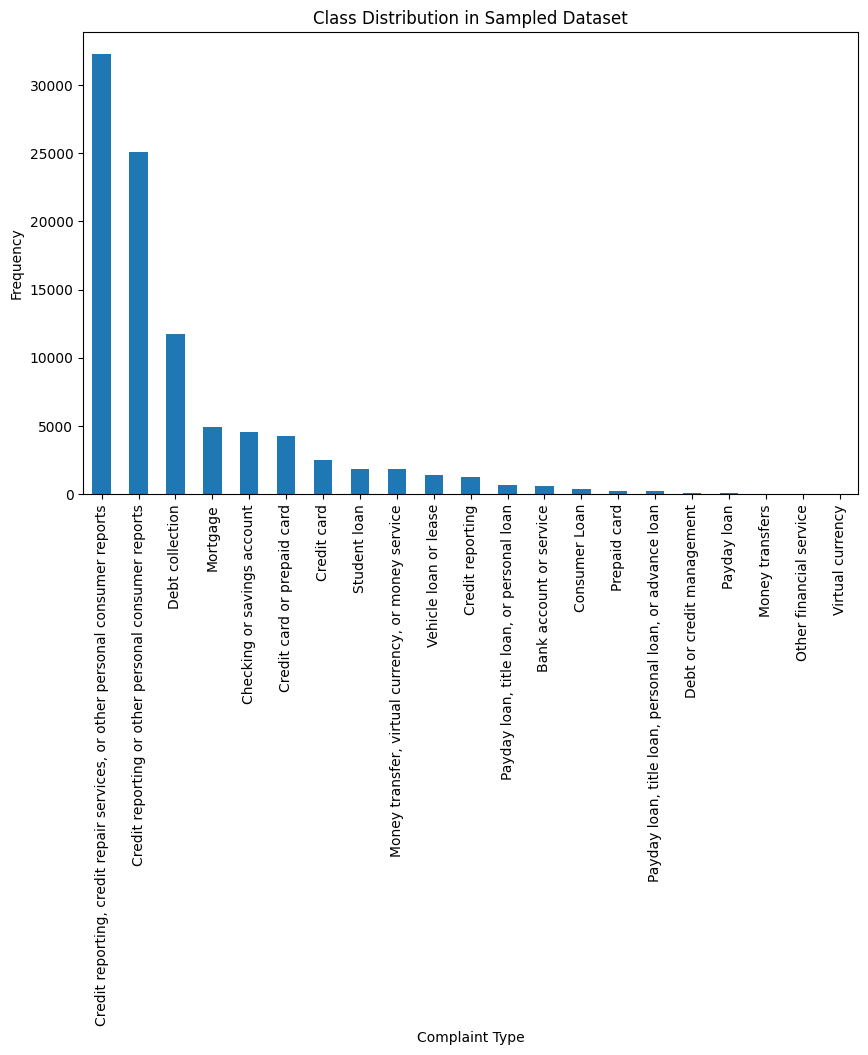

In [ ]:
sampling_fraction = 0.1

sampled_df = df.sample(frac=sampling_fraction, random_state=42)

print("Sampled Dataset:")
print(sampled_df.head())

print(f"Original Dataset Shape: {df.shape}")
print(f"Sampled Dataset Shape: {sampled_df.shape}")

class_distribution = sampled_df['Product'].value_counts()
print("\nClass Distribution in Sampled Dataset:")
print(class_distribution)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title("Class Distribution in Sampled Dataset")
plt.xlabel("Complaint Type")
plt.ylabel("Frequency")
plt.show()


---

Let's examine the distribution of ***complaints*** types in our dataset. You'll notice that some products have significantly more instances than others, and some categories are quite similar. For example:

- Multiple categories might refer to similar financial products
- Some categories might have very few examples
- Certain categories might be subcategories of others

You have two main approaches to handle this situation:

1. **Merging Similar Classes:** Identify categories that represent similar products/services and Combine them to create more robust, general categories

2. **Selecting Major Classes:** Only select the categories with sufficient representation



> You may choose any approach, but after this step, your data must include **at least five** distinct classes.



In [ ]:

df = sampled_df
print("Initial Distribution of Complaints:")
category_counts = df['Product'].value_counts()
print(category_counts)

threshold = 0.05 * len(df)
under_represented = category_counts[category_counts < threshold]
print("\nUnder-represented Classes:")
print(under_represented)

merge_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit Reporting',
    'Credit reporting or other personal consumer reports': 'Credit Reporting',
    'Credit reporting': 'Credit Reporting',
    'Credit card or prepaid card': 'Credit Card',
    'Credit card': 'Credit Card',
    'Checking or savings account': 'Bank Accounts',
    'Bank account or service': 'Bank Accounts',
    'Payday loan, title loan, or personal loan': 'Payday Loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Payday Loan',
    'Payday loan': 'Payday Loan',
    'Money transfer, virtual currency, or money service': 'Money Transfers',
    'Money transfers': 'Money Transfers',
    'Virtual currency': 'Money Transfers',
    'Debt collection': 'Debt Collection',
    'Debt or credit management': 'Debt Collection',
    'Consumer Loan': 'Other Loans',
    'Vehicle loan or lease': 'Other Loans',
    'Student loan': 'Other Loans',
    'Prepaid card': 'Other Financial Services',
    'Other financial service': 'Other Financial Services'
}

df['Merged_Product'] = df['Product'].replace(merge_mapping)
df['Text'] = df['Consumer complaint narrative']
df= df.drop('Consumer complaint narrative',axis=1)
df= df.drop('Product',axis=1)


top_5 = df['Merged_Product'].value_counts().nlargest(5).index
df = df[df['Merged_Product'].isin(top_5)]

merged_counts = df['Merged_Product'].value_counts()
print("\nDistribution After Merging:")
print(merged_counts)

print("\nFinal Classes:")
print(merged_counts.index.tolist())
print(df.head())
# Step 5: Save processed data
df.to_csv('processed_complaints.csv', index=False)
print("\nProcessed data saved to 'processed_complaints.csv'.")


Initial Distribution of Complaints:
Product
Credit reporting, credit repair services, or other personal consumer reports    32262
Credit reporting or other personal consumer reports                             25121
Debt collection                                                                 11727
Mortgage                                                                         4941
Checking or savings account                                                      4566
Credit card or prepaid card                                                      4269
Credit card                                                                      2504
Student loan                                                                     1880
Money transfer, virtual currency, or money service                               1829
Vehicle loan or lease                                                            1439
Credit reporting                                                                 1231
Payday loa

---
### 1.4 Data Encoding and Text Preprocessing

Before training our model, we need to prepare both our target labels and text data. This involves converting categorical labels into numerical format and cleaning our text data to improve model performance.

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('processed_complaints.csv')

label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Merged_Product'])
print("Label Encoding Completed. Classes:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

data['Text'] = data.get('Text', 'No text provided')

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['Text'] = data['Text'].apply(preprocess_text)

data['Word_Count'] = data['Text'].apply(lambda x: len(x.split()))
data = data[data['Word_Count'] >= 10]
data = data.drop('Word_Count',axis=1)

merged_counts = data['Label'].value_counts()
print("\nDistribution After fraction:")
print(merged_counts)
print("\nHead of data")
print(data.head())
data.to_csv('preprocessed_complaints.csv', index=False)
print("\nPreprocessed data saved to 'preprocessed_complaints.csv'.")


Label Encoding Completed. Classes:
{'Bank Accounts': 0, 'Credit Card': 1, 'Credit Reporting': 2, 'Debt Collection': 3, 'Mortgage': 4}

Distribution After fraction:
Label
2    57989
3    11696
1     6741
0     5133
4     4933
Name: count, dtype: int64

Head of data
     Merged_Product                                               Text  Label
0  Credit Reporting  upon reviewing my credit report i have identif...      2
1          Mortgage  i was doing a rate check to refinance the agen...      4
2  Credit Reporting  this is my nd request that i have been a victi...      2
3  Credit Reporting  im sending this compliant to inform credit bur...      2
4  Credit Reporting  im submitting a complaint to you today to info...      2

Preprocessed data saved to 'preprocessed_complaints.csv'.


## 1.5 Dataset Creation and Tokenization

For training our BERT model, we need to:
1. Create a custom Dataset class that will handle tokenization
2. Split the data into training and testing sets
3. Use BERT's tokenizer to convert text into a format suitable for the model

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

class ComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):

        return len(self.texts)

    def __getitem__(self, idx):

        text = self.texts[idx]
        label = self.labels[idx]


        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )


        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()


        label = torch.tensor(label, dtype=torch.long)


        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import pandas as pd
data = pd.read_csv('preprocessed_complaints.csv')
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'],
    data['Label'],
    test_size=0.2,
    random_state=42,
    stratify=data['Label']
)

# 2. Initialize tokenizer and create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_dataset = ComplaintDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=512
)

test_dataset = ComplaintDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=512
)

# 3. Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Part 2: Training a Small-Size BERT Model

In this part, we will explore how to build and train a small-sized BERT model for our classification task. Instead of using the full-sized BERT model, which is computationally expensive, we will create a smaller version using the Transformers library.

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertConfig
from torch import nn

num_labels = len(data['Label'].unique())
print(num_labels)

config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=512,
    hidden_dropout_prob=0.2
)

model = BertForSequenceClassification(config)



total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


5
Total parameters: 10121221
Trainable parameters: 10121221


---

Now that you have defined your model, it's time to train it!☠️

Training a model of this size can take some time, depending on the available resources. To manage this, you can train your model for just **2–3 epochs** to demonstrate progress. Here are some hints:
- **Training Metrics:** Ensure you print enough metrics, such as loss and accuracy, to track the training progress.
- **Interactive Monitoring:** Use the `tqdm` library to display the progress of your training loop in real-time.

In [ ]:
import torch
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# 1. Initialize optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)
# 2. Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits


        loss.backward()


        optimizer.step()


        running_loss += loss.item()


        _, predicted = torch.max(logits, dim=1)

        # Calculate accuracy
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        torch.cuda.empty_cache()


    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds * 100
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    model_save_path = f"model_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")


model.eval()
test_correct_preds = 0
test_total_preds = 0
test_running_loss = 0.0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Set", dynamic_ncols=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)


        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )


        loss = outputs.loss
        logits = outputs.logits


        test_running_loss += loss.item()


        _, predicted = torch.max(logits, dim=1)


        test_correct_preds += (predicted == labels).sum().item()
        test_total_preds += labels.size(0)

avg_test_loss = test_running_loss / len(test_loader)
test_accuracy = test_correct_preds / test_total_preds * 100
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


cuda


Epoch 1/3: 100%|██████████| 4325/4325 [09:32<00:00,  7.56it/s]


Epoch 1/3 - Loss: 0.6283, Accuracy: 77.94%
Model saved to model_epoch_1.pth


Epoch 2/3: 100%|██████████| 4325/4325 [08:35<00:00,  8.39it/s]


Epoch 2/3 - Loss: 0.3463, Accuracy: 88.30%
Model saved to model_epoch_2.pth


Epoch 3/3: 100%|██████████| 4325/4325 [09:15<00:00,  7.79it/s]


Epoch 3/3 - Loss: 0.2963, Accuracy: 90.03%
Model saved to model_epoch_3.pth


Evaluating on Test Set: 100%|██████████| 1082/1082 [01:22<00:00, 13.05it/s]

Test Loss: 0.3173, Test Accuracy: 88.91%


## Part 3: Fine-Tuning TinyBERT with LoRA

As you have experienced, training even a small-sized BERT model can be computationally intensive and time-consuming. To address these challenges, we explore **Parameter-Efficient Fine-Tuning (PEFT)** methods, which allow us to utilize the power of large pretrained models without requiring extensive resources.

---

### **Parameter-Efficient Fine-Tuning (PEFT)**

PEFT methods focus on fine-tuning only a small portion of the model’s parameters while keeping most of the pretrained weights frozen. This drastically reduces the computational and storage requirements while leveraging the rich knowledge embedded in pretrained models.

One popular PEFT method is LoRA (Low-Rank Adaptation).

- **What is LoRA?**

LoRA introduces a mechanism to fine-tune large language models by injecting small low-rank matrices into the model's architecture. Instead of updating all parameters during training, LoRA trains these small matrices while keeping the majority of the original parameters frozen.  This is achieved as follows:

1. **Frozen Weights**: The pretrained weights of the model, represented as a weight matrix $ W \in \mathbb{R}^{d \times k} $, remain **frozen** during fine-tuning.

2. **Low-Rank Decomposition**:
   Instead of directly updating $ W $, LoRA introduces two trainable matrices, $ A \in \mathbb{R}^{d \times r} $ and $ B \in \mathbb{R}^{r \times k} $, where $ r \ll \min(d, k) $.  
   These matrices approximate the update to $ W $ as:
   $$
   \Delta W = A \cdot B
   $$

   Here, $ r $, the rank of the decomposition, is a key hyperparameter that determines the trade-off between computational cost and model capacity.

3. **Adaptation**:
   During training, instead of updating $ W $, the adapted weight is:
   $$
   W' = W + \Delta W = W + A \cdot B
   $$
   Only the low-rank matrices $ A $ and $ B $ are optimized, while $ W $ remains fixed.

4. **Efficiency**:
   Since $ r $ is much smaller than $ d $ and $ k $, the number of trainable parameters in $ A $ and $ B $ is significantly less than in $ W $. This makes the approach highly efficient both in terms of computation and memory.

---

###  **Fine-Tuning TinyBERT**

For this part, we will fine-tune **TinyBERT**, a distilled version of BERT, using the LoRA method.

- **What is TinyBERT?**

TinyBERT is a lightweight version of the original BERT model created through knowledge distillation. It significantly reduces the model size and inference latency while preserving much of the original BERT’s effectiveness. Here are some key characteristics of TinyBERT:
- It is designed to be more resource-efficient for tasks such as classification, question answering, and more.
- TinyBERT retains a compact structure with fewer layers and parameters, making it ideal for fine-tuning with limited computational resources.


> Similar to the previous section, training this model might take some time. Given the resource limitations, you can train the model for just **2-3 epochs** to demonstrate the process.


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

In [ ]:
from transformers import AutoModel, AutoTokenizer
from peft import LoraConfig


model_name = "prajjwal1/bert-tiny"

num_labels = len(data['Label'].unique())
print(num_labels)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    bias="none",
    task_type="SEQ_CLS"
)


5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from peft import get_peft_model
from torch.optim import AdamW
import torch.nn as nn

lora_model = get_peft_model(base_model, lora_config)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_trainable_parameters(lora_model)}")

###################### Training configuration ########################

optimizer = AdamW(lora_model.parameters(), lr=5e-5)


criterion = nn.CrossEntropyLoss()


Trainable parameters: 8837


In [ ]:
from tqdm import tqdm
import torch

###################### Training Loop ########################

num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lora_model.to(device)
# Training loop
for epoch in range(num_epochs):
    lora_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()


        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)


        outputs = lora_model(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            labels=labels.to(device)
        )


        loss = outputs.loss
        total_loss += loss.item()


        loss.backward()
        optimizer.step()


        preds = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)


    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

###################### Model Evaluation ########################
lora_model.eval()
total_loss = 0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = lora_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Calculate loss
        loss = outputs.loss
        total_loss += loss.item()

        # Calculate predictions and accuracy
        preds = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)


test_loss = total_loss / len(test_loader)
test_accuracy = correct_predictions / total_samples
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


cuda


  0%|          | 0/4325 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4325/4325 [05:42<00:00, 12.61it/s]


Epoch 1/3 - Loss: 0.8653, Accuracy: 0.6957


100%|██████████| 4325/4325 [06:33<00:00, 10.98it/s]


Epoch 2/3 - Loss: 0.6647, Accuracy: 0.7743


100%|██████████| 4325/4325 [05:36<00:00, 12.87it/s]


Epoch 3/3 - Loss: 0.5550, Accuracy: 0.8126


100%|██████████| 1082/1082 [01:12<00:00, 14.89it/s]

Test Loss: 0.4848, Test Accuracy: 0.8377
